# **Climate Change: Analysis of Emissions and Their Relationship to GDP**

### **Zagaria Simone, Student ID: 2145389, Project for Big Data for Official Statistics aa 2024/2025**

# **Introduction**

In this project we aim to analyze the total emissions from various countries around the world between 2000 and 2020. Our goal is to predict future emissions, classify countries based on their emission levels and analyze the trends. Additionally, we will also compare the emissions to the GDP of each country to understand the correlation between the two variables.

To achieve this, we will be working with two datasets. 
The first tracks the sources, types, and total emissions (CH4, N2O, CO2, etc.) per country from 2000 to 2020. All data are official figures from the United Nations's Food and Agriculture Organization (FAO) and are measured in kilotonnes.
Meanwhile, the second dataset contains GDP values for each country from 1964 to 2017. The data in this case is taken from the World Bank Dataset. 

The object in this analysis understand the impact of economic activities on global warming, identify the countries with the highest consumption levels, predict future emissions and lastly, to hold countries accountable for their contributions to the environmental crisis 

# **Importing Libraries**

Importing the libraries needed for the project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.ticker as ticker
from sklearn.linear_model import LinearRegression
from prophet import Prophet
import folium
from geopy.geocoders import Nominatim
import scipy.stats as stats



# **1. Preprocessing**

Before diving into the analysis, we needed to preprocess the data to ensure its quality and consistency. This process involved handling missing values, normalizing  the data and selecting only the columns pertinent to the analysis.

In [2]:
# Let's first import the datasets


df_emissions = pd.read_csv('TotalEmissionsPerCountry.csv')  # emission dataset import
df_gdp = pd.read_csv('gdp_data.csv')  # GDP dataset import



We observe that both datasets are currently in "Wide" format. Let's convert them to "Long" format to simplify the future analysis. 
Before doing so, we'll remove any unnecessary columns to reduce memory usage and improve efficiency.
Furthermore, we notice that there is an "unnamed column" in the GDP dataset and we'll remove it

In [3]:
df_emissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49260 entries, 0 to 49259
Data columns (total 25 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Area     49260 non-null  object 
 1   Item     49260 non-null  object 
 2   Element  49260 non-null  object 
 3   Unit     49260 non-null  object 
 4   2000     46930 non-null  float64
 5   2001     45401 non-null  float64
 6   2002     45495 non-null  float64
 7   2003     45516 non-null  float64
 8   2004     45521 non-null  float64
 9   2005     45786 non-null  float64
 10  2006     45593 non-null  float64
 11  2007     45442 non-null  float64
 12  2008     45423 non-null  float64
 13  2009     45410 non-null  float64
 14  2010     45838 non-null  float64
 15  2011     45249 non-null  float64
 16  2012     45504 non-null  float64
 17  2013     45395 non-null  float64
 18  2014     45270 non-null  float64
 19  2015     45194 non-null  float64
 20  2016     45170 non-null  float64
 21  2017     450

In [4]:
df_gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 63 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    264 non-null    object 
 1   Country Code    264 non-null    object 
 2   Indicator Name  264 non-null    object 
 3   Indicator Code  264 non-null    object 
 4   1960            124 non-null    float64
 5   1961            124 non-null    float64
 6   1962            125 non-null    float64
 7   1963            125 non-null    float64
 8   1964            125 non-null    float64
 9   1965            136 non-null    float64
 10  1966            137 non-null    float64
 11  1967            141 non-null    float64
 12  1968            145 non-null    float64
 13  1969            145 non-null    float64
 14  1970            153 non-null    float64
 15  1971            155 non-null    float64
 16  1972            155 non-null    float64
 17  1973            155 non-null    flo

We also notice that the only measure of emissions is Kilotonnes, so we can assume all the emissions are measured in **Kilotonnes** and drop this column to save memory usage and make the dataset more efficient.

In [5]:
print(df_emissions['Unit'].unique())

['kilotonnes']


In [ ]:

# We drop the columns 'Country Code', 'Indicator Name', 'Indicator Code' as they are not needed for our analyses 
# and we also remove the erroneous column 'Unnamed: 62'
df_gdp = df_gdp.drop(columns=['Country Code', 'Indicator Name', 'Indicator Code','Unnamed: 62'])
df_emissions = df_emissions.drop(columns=['Unit'])

# We rename the 'Area' column in the emission dataset to match the GDP dataset to facilitate the join
df_emissions.rename(columns={'Area': 'Country Name'}, inplace=True)

# We transform both the dataset in 'Long' format to facilitate analyses and visualization
df_emissions_long = pd.melt(df_emissions, id_vars=["Country Name", "Item", "Element"], var_name="Year", value_name="Emissions")
df_gdp_long = pd.melt(df_gdp, id_vars=["Country Name"], var_name="Year", value_name="GDP")

# Next, we sort by the year and the country and we apply temporal interpolation to fill
# the NaN values in the 'Emissions' and 'GDP' columns

df_gdp_long = df_gdp_long.sort_values(['Country Name', 'Year'])
df_emissions_long = df_emissions_long.sort_values(['Country Name', 'Item', 'Element', 'Year'])

df_emissions_long['Emissions'] = df_emissions_long.groupby(['Country Name', 'Item', 'Element'], group_keys=False)['Emissions'].apply(lambda group: group.interpolate(method='linear'))
df_gdp_long['GDP'] = df_gdp_long.groupby(['Country Name'], group_keys=False)['GDP'].apply(lambda group: group.interpolate(method='linear'))

# group_keys = False ensures that the index is not modified within the groupby operation, preserving the original 
# dataframe index and thus avoiding index conflict errors when inserting the interpolated series.

# Next, we remove the negative emissions (data cleaning)
df_emissions_long = df_emissions_long[df_emissions_long['Emissions'] >= 0]
df_gdp_long = df_gdp_long[df_gdp_long['GDP'] >= 0]

# Lastly, we convert in both datasets the column Year in numeric format to allow temporal analyses and temporal interpolarion
df_emissions_long['Year'] = pd.to_datetime(df_emissions_long['Year'], format='%Y')
df_gdp_long['Year'] = pd.to_datetime(df_gdp_long['Year'], format='%Y')


We notice that there are no more NaN values in both datasets

In [7]:
print(df_emissions_long.isna().any())

Country Name    False
Item            False
Element         False
Year            False
Emissions       False
dtype: bool


In [8]:
print(df_gdp_long.isna().any())

Country Name    False
Year            False
GDP             False
dtype: bool


In [9]:
df_emissions_long.info()

<class 'pandas.core.frame.DataFrame'>
Index: 993570 entries, 206 to 1033285
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Country Name  993570 non-null  object        
 1   Item          993570 non-null  object        
 2   Element       993570 non-null  object        
 3   Year          993570 non-null  datetime64[ns]
 4   Emissions     993570 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 45.5+ MB


In [10]:
df_gdp_long.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11796 entries, 1 to 15311
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Country Name  11796 non-null  object        
 1   Year          11796 non-null  datetime64[ns]
 2   GDP           11796 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 368.6+ KB


Saving the cleaned version of the datasets as csv files

In [11]:
df_emissions_long.to_csv('emissions_clean_interpolated.csv', index=False)
df_gdp_long.to_csv('gdp_clean_interpolated.csv', index=False)

# **2. Exploratory Data Analysis (EDA)**

Let's explore the main focus of this project: the Emissions dataset, examining through an exploratory data analysis. This will include analyzing key distribution patterns and understanding temporal and regional trends.
Let's first observe some general information about the contents of the dataset:


In [ ]:
# Checking the countries present in the dataset
print("Countries present in the dataset:")
print(np.size(df_emissions_long['Country Name'].unique()))

Countries present in the dataset:
227


In [14]:
# Checking the Elements present in the dataset
print("Types of emissions present in the dataset:")
print(df_emissions_long['Element'].unique())

Types of emissions present in the dataset:
['Emissions (CH4)' 'Emissions (CO2)' 'Emissions (CO2eq) (AR5)'
 'Emissions (CO2eq) from CH4 (AR5)' 'Emissions (CO2eq) from N2O (AR5)'
 'Emissions (N2O)' 'Direct emissions (N2O)' 'Indirect emissions (N2O)'
 'Emissions (CO2eq) from F-gases (AR5)']


In [15]:
# Descriptive statistics for emissions
print("Descriptive statistics for emissions:")
print(df_emissions_long[['Emissions']].describe())

# Statistical summary per Element
summary_stats = df_emissions_long.groupby("Element")["Emissions"].describe()
print("\nSummary statistics per Element:\n", summary_stats)

Descriptive statistics for emissions:
          Emissions
count  9.935700e+05
mean   9.750640e+03
std    1.386564e+05
min    0.000000e+00
25%    7.780000e-02
50%    1.179880e+01
75%    5.688490e+02
max    1.409145e+07

Summary statistics per Element:
                                          count          mean            std  \
Element                                                                       
Direct emissions (N2O)                 32403.0     14.034029      57.411986   
Emissions (CH4)                       143470.0    311.602196    1714.613702   
Emissions (CO2)                       105104.0  28040.970380  263944.619234   
Emissions (CO2eq) (AR5)               198465.0  24286.545280  237693.666960   
Emissions (CO2eq) from CH4 (AR5)      140551.0   8863.302413   48480.422249   
Emissions (CO2eq) from F-gases (AR5)   14310.0   6863.774827   32727.755278   
Emissions (CO2eq) from N2O (AR5)      163517.0   3237.810904   24990.481671   
Emissions (N2O)                      

We begin with a heatmap showing the total emissions per country to provide an immediate visual understanding of the global situation.

We’ll use a logarithmic scale for our heatmap of country emissions. This approach helps will ensure that countries with extremely high emissions don’t dominate the visualization, allowing for clearer insights for countries with lower emissions. A logarithmic scale is commonly used in datasets with high variability, as it highlights smaller values more effectively, improving overall data interpretation by making smaller-emission countries more visible and distinct in the heatmap.

In [ ]:

df_total_emissions = df_emissions_long.groupby('Country Name')['Emissions'].sum().reset_index()

df_total_emissions['Log Emissions'] = np.log1p(df_total_emissions['Emissions'])  # log1p is log(1 + x), so it will handle the emissions even if they are zero

# Heatmap of the countries where the color represents the quantity of the emissions
fig = px.choropleth(df_total_emissions, 
                    locations="Country Name",
                    locationmode='country names',
                    color="Log Emissions",
                    hover_name="Country Name",
                    color_continuous_scale="Inferno",
                    title="Emissions Heatmap per Country")

fig.update_layout(
    width=800,
    height=500
)

fig.show()


The map highlights that North America and East Asia are the regions with the highest emissions, while Africa has the lowest. This can indicate how economic development and industrialization strongly influence a country's emission levels

Next, we have a chart that chart illustrates the trend of gas emissions by type from 2000 to 2020

c:\Users\nephr\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

c:\Users\nephr\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

c:\Users\nephr\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

c:\Users\nephr\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning:

When gr

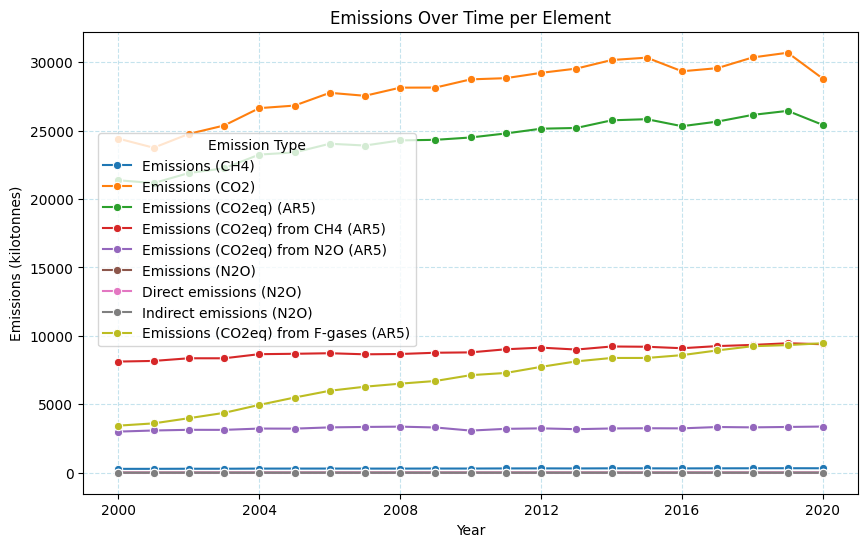

In [17]:
# Visualization of emissions over time for each type of emission
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_emissions_long, x="Year", y="Emissions", hue="Element", marker="o",errorbar=None)

plt.title("Emissions Over Time per Element")
plt.xlabel("Year")
plt.ylabel("Emissions (kilotonnes)")
plt.legend(title="Emission Type", loc='center left', bbox_to_anchor=(0.01, 0.55))
plt.grid(True, linestyle='--', color='lightblue', alpha=0.7) 
plt.show()

We can see how CO2  emissions dominate, showing a steady increase over time, rising by approximately 20% over the last 2 decades. Minor contributors, such as methane (CH₄), nitrous oxide (N₂O) and indirect emissions, tend to remain relatively stable.

Next, to better observe how the emissions are composed and how much each type contribute to the total quantity of the emissions, we construct a pie graph containing the various types of emissions in the database.

In [18]:
# We create a new dataset grouping by the elements and we summing the emissions
data_pie = df_emissions_long.groupby('Element')['Emissions'].sum().reset_index()

# We calculate the total and the percentages of the various elements
total_percentage_emissions = data_pie['Emissions'].sum()
data_pie['Percentage'] = (data_pie['Emissions'] / total_percentage_emissions) * 100

# We treat the emissions under 5% as a single element to keep the graph clear. To do this
# we created a separated dataframe containing the sum of the other elements and their percentage over the total
main_elements = data_pie[data_pie['Percentage'] >= 5]
other_elements = data_pie[data_pie['Percentage'] < 5]
others_total = other_elements['Emissions'].sum()

others_row = pd.DataFrame({
    'Element': ['Others'],
    'Emissions': [others_total],
    'Percentage': [(others_total / total_percentage_emissions) * 100]
})
data_pie_final = pd.concat([main_elements, others_row], ignore_index=True)

palette = sns.color_palette("plasma", len(data_pie_final)).as_hex()

# Creating the interactive pie chart
fig = px.pie(
    data_pie_final, 
    values='Emissions', 
    names='Element', 
    title='Distribution of CO2 Emissions by Type',
    color_discrete_sequence=palette,
    hole=0.3
)

fig.update_layout(width=800, height=600)
fig.show()



We can observe how the main polluting gas is CO2, having a share of 80% among all polluting gasses, and it is followed by methane (12.9 %) and nitrous oxide (5.5%). Other gasses only occupy 1.5% of the total share.

Now we want to graphically check per year the trend of total emissions, to do that, we'll create a bar graph, as done below:

In [ ]:
# We group the data by the year to sum all the emissions
total_emissions_by_year = df_emissions_long.groupby('Year')['Emissions'].sum().reset_index()

fig = px.bar(
    total_emissions_by_year, 
    x='Year', 
    y='Emissions', 
    title='Total CO2 Emissions by Year', 
    labels={'Emissions': 'Total Emissions (in kilotonnes)', 'Year': 'Year'},
    color='Emissions', 
    color_continuous_scale='Plasma'
)

fig.show()


We immediatly notice that the emissions have been steadily increasing over the years. With respect to 2000, in 2020 the emissions have gone up by approximately 20%

Finally, we do the top 10 countries based on total emissions:

In [20]:

# We re-use the dataset of the total emissions for each country to create a bar chart of the top 5 emissions  
# first, we sort the countries based on total emissions and take the top 5
top_5 = df_total_emissions.sort_values(by='Emissions', ascending=False).head(10)

# Create the bar chart
fig = px.bar(top_5, 
    x='Country Name', 
    y='Emissions', 
    title='Top 10 Countries with Highest Emissions', 
    labels={'Emissions': 'Total Emissions', 'Country Name': 'Country'}, 
    color='Emissions', 
    color_continuous_scale='plasma'
)

fig.update_layout(xaxis_tickangle=-45)
fig.show()


The top 10 countries include major emerging and industrialized countries, with China leading as expected, followed by the United States and Brazil

In [21]:

# We do the same thing for the bottom 5 countries for emissions  
# first, we sort the countries based on total emissions and take the top 5
bottom_5 = df_total_emissions.sort_values(by='Emissions', ascending=True).head(10)

# Create the bar chart
fig = px.bar(bottom_5, 
    x='Country Name', 
    y='Emissions', 
    title='Top 10 Countries with Lowest Emissions', 
    labels={'Emissions': 'Total Emissions', 'Country Name': 'Country'}, 
    color='Emissions', 
    color_continuous_scale='plasma'
)

fig.update_layout(xaxis_tickangle=-45)
fig.show()

The countries with the lowest emissions are small, independent states or territories, such as the Vatican, Montserrat, and Norfolk Island. We can observe how global powers contribute disproportionately to global emissions.

# 3. Linear Regression

Now, let's compute the Linear Regression between time and total global CO2 emissions. By analyzing the relationship between the years (as the x-axis) and total global emissions (as the y-axis), we aim to understand how emissions have evolved over time. This approach will allow us to identify the general trend, measure the rate of change in emissions, and assess if the increase has been consistent.

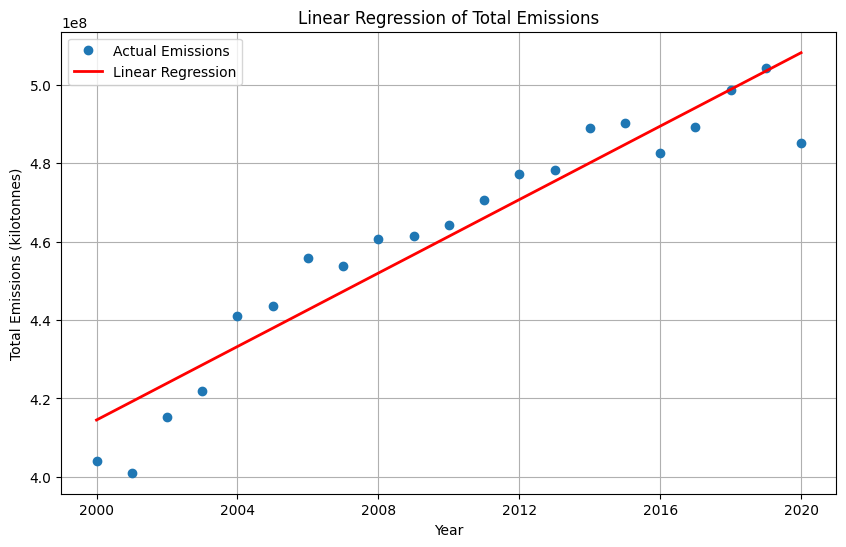

Coefficient (slope): 4683135.166055259


In [ ]:

# We reuse the the dataset of the total emission by year for regression. We use the total emissions in the world.
# As x-axis we choose the year and as y-axis we chose the emissions

# Prepare the variables for regression
X = total_emissions_by_year['Year'].dt.year.astype(int).values.reshape(-1, 1) 
y = total_emissions_by_year['Emissions'].values

# Initialize the linear regression model and train it
model = LinearRegression()
model.fit(X, y)

# Calculate the predicted values for the regression line
y_pred = model.predict(X)

# Visualize the graph with the linear regression
plt.figure(figsize=(10, 6))
plt.plot(total_emissions_by_year['Year'], total_emissions_by_year['Emissions'], 'o', label="Actual Emissions")
plt.plot(total_emissions_by_year['Year'], y_pred, color='red', linewidth=2, label="Linear Regression")
plt.title('Linear Regression of Total Emissions')
plt.xlabel('Year')
plt.ylabel('Total Emissions (kilotonnes)')
plt.legend()
plt.grid(True)
plt.show()

slope = model.coef_[0]
print(f"Coefficient (slope): {slope}")


The graph shows a clear, steady increase in CO₂ emissions from 2000 to 2020. The regression line (in red) closely follows the actual data points (in blue), suggesting that the rise in emissions over time has been nearly linear.

The slope value is positive, indicating that emissions have risen over the years. From the graph, we can observe that The regression suggests that the rise in emissions has been nearly linear with only a few points significantly deviating from the trend line. From 2010 onwards, there are a few larger fluctuations from the line, but the overall trend remains consistent.


# 4. Classification

Now, let's perform a classification of countries based on their CO2 emission levels. Using the dataset, we categorize countries into five distinct groups according to emission quantiles, from very low to very high emission countries. Using this classification, we will create a map with each country colored in a different color, representing its emission category. 

This classification allows us to easily categorize countries based on their emission levels and assign them to specific groups.

In [23]:
# Calculating the quantiles for the classification
q_10 = df_total_emissions['Emissions'].quantile(0.10)
q_40 = df_total_emissions['Emissions'].quantile(0.40)
q_70 = df_total_emissions['Emissions'].quantile(0.70)
q_90 = df_total_emissions['Emissions'].quantile(0.90)

# Initializing the geocoder
geolocator = Nominatim(user_agent="geoapi")

# Function to get coordinates from a country name
def get_coordinates(country_name):
    try:
        location = geolocator.geocode(country_name)
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except Exception as e:
        print(f"Error for {country_name}: {e}")
        return None, None

# Creating the map
map = folium.Map(location=[20, 0], zoom_start=2)

# Looping through the data and getting the needed data + classifying using the calculated quantiles
for index, row in df_total_emissions.iterrows():
    country_name = row['Country Name']
    emissions = row['Emissions']
    
    if emissions >= q_90:
        color = 'darkred'
    elif emissions >= q_70 and emissions < q_90:
        color = 'red'
    elif emissions >= q_40 and emissions < q_70:
        color = 'orange'
    elif emissions >= q_10 and emissions < q_40:
        color = 'green'
    elif emissions < q_10:
        color = 'lightgray'

    # Getting the coordinates needed and applying the marker id they are valid
    latitude, longitude = get_coordinates(country_name)

    if latitude and longitude:
        folium.Marker([latitude, longitude],
                      popup=f"{country_name}: {emissions} kilotonnes",
                      icon=folium.Icon(color=color)).add_to(map)

display(map)


Error for C?e d'Ivoire: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=C%3Fe+d%27Ivoire&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
Error for Mali: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Mali&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


# Time series Prediction

Now, let's use time series prediction to forecast future CO2 emissions. We will use Prophet, a forecasting tool specialized in time series data, to analyze the trend in total annual emissions and project this trend into the future. 
This prediction allows us to visualize potential future emissions trends and assess if the upward trajectory is likely to continue.

C:\Users\nephr\AppData\Local\Temp\ipykernel_3060\4281932724.py:3: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.

13:15:33 - cmdstanpy - INFO - Chain [1] start processing
13:15:33 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\nephr\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.

C:\Users\nephr\AppData\Local\Temp\ipykernel_3060\4281932724.py:26: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.

C:\Users\nephr\AppData\Local\Temp\ipykernel_3060\4281932724.py:27: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



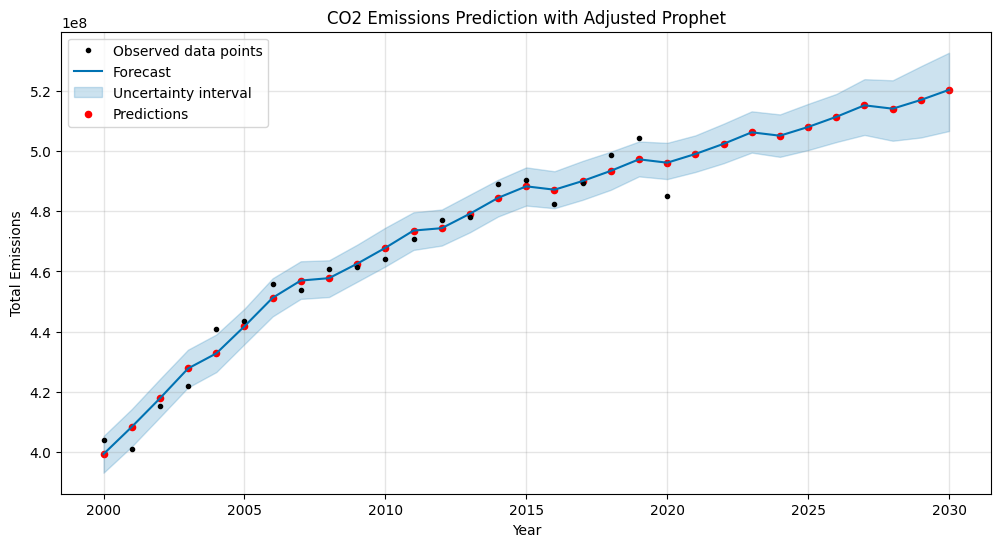

      Year  Predicted Emissions
2021-12-31         4.989667e+08
2022-12-31         5.023290e+08
2023-12-31         5.061555e+08
2024-12-31         5.050354e+08
2025-12-31         5.079261e+08
2026-12-31         5.112883e+08
2027-12-31         5.151149e+08
2028-12-31         5.139947e+08
2029-12-31         5.168854e+08
2030-12-31         5.202477e+08


In [ ]:
# Renaming the columns as requested by Prophet, as it requires ds as the date column, y as the value
total_emissions_by_year.columns = ['ds', 'y']
total_emissions_by_year['ds'] = pd.date_range(start="2000-01-01", periods=21, freq="Y")

# Initialize and configure the Prophet model
model = Prophet()  # Reduce sensitivity to changepoints
model.fit(total_emissions_by_year)  # Fit the model to the data

# Create a dataframe for future predictions
future = model.make_future_dataframe(periods=10, freq='Y')
forecast = model.predict(future) 

# Plot the predictions
fig, ax = plt.subplots(figsize=(12, 6))
model.plot(forecast, ax=ax)
ax.scatter(forecast['ds'], forecast['yhat'], color='red', label='Predictions', s=20)
plt.title('CO2 Emissions Prediction with Adjusted Prophet')
plt.xlabel('Year')
plt.ylabel('Total Emissions')
plt.legend()
plt.grid(True)
ax.set_xticks(pd.date_range(start='2000-01-01', end=future['ds'].max(), freq='5Y'))
ax.set_xticklabels([date.year for date in pd.date_range(start='2000-01-01', end=future['ds'].max(), freq='5Y')])

plt.show()

# Output future predictions as text
future_predictions = forecast[forecast['ds'].dt.year >= 2021][['ds', 'yhat']]
future_predictions.columns = ['Year', 'Predicted Emissions']
print(future_predictions.to_string(index=False))

In this graph, the black dots represent the observed data points for 
total CO2 emissions over time (provided by the dataset), while the blue 
line represents the forecasted trend generated by the Prophet model. The 
red dots correspond to the predicted values for each future year, 
providing an annual point-by-point projection. 
The shaded blue area around the forecast line illustrates the 
uncertainty interval, indicating the range within which future emissions 
are expected to fall with a certain confidence level.

From the graph, we observe a steady upward trend in CO₂ emissions from 
2000 through 2020, followed by a predicted continuation of this trend in 
the next 10 years.  The rise in emission in 2030, according to the 
forecast, indicates a 8.83% rise compared to 2020, and a 30.70% rise 
compared to 2000. This forecast highlights the potential for continued 
growth in global emissions and the worsening of climate catastrophies 
unless significant interventions occur.

# 5. Multivariate Analysis

In this section, we will perform a multivariate analysis to examine the relationship between CO2 emissions and GDP. By merging the emissions and GDP datasets on both country and year, we create a dataset that contains for each year for each country, the total emissions and its GDP. This approach enables us to analyze how economic activity (represented by GDP) correlates with environmental impact (represented by emissions), both on a global scale and in individual countries.

In [ ]:
df_emissions_total = df_emissions_long.groupby(['Country Name', 'Year'])['Emissions'].sum().reset_index()

In [ ]:
print(df_emissions_total)

     Country Name       Year     Emissions
0     Afghanistan 2000-01-01  2.613449e+05
1     Afghanistan 2001-01-01  2.403983e+05
2     Afghanistan 2002-01-01  2.906577e+05
3     Afghanistan 2003-01-01  3.001765e+05
4     Afghanistan 2004-01-01  2.988644e+05
...           ...        ...           ...
4762     Zimbabwe 2016-01-01  1.286006e+06
4763     Zimbabwe 2017-01-01  1.290779e+06
4764     Zimbabwe 2018-01-01  1.298609e+06
4765     Zimbabwe 2019-01-01  1.296947e+06
4766     Zimbabwe 2020-01-01  1.272170e+06

[4767 rows x 3 columns]


In [ ]:
# Now we make an inner join between the datasets, based on the countries and year, filtering the values present in both datasets, 
# and as such creating a new dataset.
# From this dataset we will calculate the correlation between Emissions and GDP, both in general and for each specific country

df_emissions_gdp_long = pd.merge(df_emissions_total, df_gdp_long, how='inner', left_on=['Country Name', 'Year'], right_on=['Country Name', 'Year'])
df_emissions_gdp_long['Year'] = df_emissions_gdp_long['Year'].dt.year

print(df_emissions_gdp_long.head())

# df_emissions_gdp_long.to_csv('emissions_gdp.csv', index=False)

  Country Name  Year     Emissions           GDP
0  Afghanistan  2000  261344.93160  2.512522e+09
1  Afghanistan  2001  240398.34135  2.461666e+09
2  Afghanistan  2002  290657.74980  4.128821e+09
3  Afghanistan  2003  300176.53540  4.583644e+09
4  Afghanistan  2004  298864.41650  5.285466e+09


We also check that there are no NaN values for this dataset

In [ ]:
print(df_emissions_gdp_long.isna().any())

Country Name    False
Year            False
Emissions       False
GDP             False
dtype: bool


First, we calculate the overall correlation between emissions and GDP across all countries to gain insight into the general trend. Then, we calculate the correlation for each country separately, allowing us to observe variations and identify countries where economic growth is more closely or less closely associated with emissions. The results, presented in a summary table, will help us explore whether countries with higher GDPs tend to produce more emissions or if other factors might influence this relationship.

In [ ]:
# Group by "Country Name" and calculate the correlation between "Emissions" and "GDP" for each country
correlations = {}

for country, data in df_emissions_gdp_long.groupby("Country Name"):
    if len(data) > 1:  # Calculate the correlation only if there are at least 2 years of data
        correlation = data["Emissions"].corr(data["GDP"])
        correlations[country] = correlation

# Convert the dictionary to a DataFrame for better visualization of the results
correlations_df = pd.DataFrame(list(correlations.items()), columns=["Country Name", "Correlation"])
print(correlations_df)


       Country Name  Correlation
0       Afghanistan     0.952920
1           Albania     0.087364
2           Algeria     0.753458
3    American Samoa     0.706161
4           Andorra    -0.016344
..              ...          ...
169         Uruguay     0.613019
170      Uzbekistan     0.859113
171         Vanuatu     0.641591
172          Zambia     0.884213
173        Zimbabwe     0.580614

[174 rows x 2 columns]


In [ ]:

# Calculation of the p-value between GDP and Emissions
corr_gdp_emissions, p_value_gdp_emissions = stats.pearsonr(df_emissions_gdp_long['GDP'], df_emissions_gdp_long['Emissions'])

print(f"Correlation between GDP and Emissions: {corr_gdp_emissions}, p-value: {p_value_gdp_emissions}")

Correlation between GDP and Emissions: 0.733492688345309, p-value: 0.0
Correlation between Year and Emissions: 0.019468360479715844, p-value: 0.27814662007907975


The results presented a correlation value of over 0.7, indicating an overall strong correlation between the two variables.  However, while this was true for most countries, but some had minor  or even negative correlation, indicating that even other factors may influence this relationship.

The p-value equals to zero indicates that the observed correlation is statistically significant, and it is highly unlikely to be random.
